## Electric vehicle driving range prediction

The main challenge of EVs is to determine and increase the trip distance precisely. To understand the importance of this issue, the concept of energy consumption rate (ECR) shoud be followed at first, vehicle manufacturers set a specific factor as the ECR at production which is explained with kilowatthours per hundred kilometers. The car manufacturer calculates the ECR parameter under certain circumstances, meaning that it differs from actual value in real world. In reality, the use of auxiliary equipment, air temperature, traffic volume, type of the road, driving patterns and the driving speed noticeably affect the ECR. Therefore, achieving high precisions in trip distance estimation is cosidered as a complex problem with many influencing concepts changing it. 

Here, using a publicity available dataset, driving range estimation of a specific electric vehicle model is examined. Multiple regression models are trained based on the features like the avarage speed, type of the route and driving style, then the driving range prediction accuracy is investigated using mean absulote error.  

To develop the driving range estimator, several popular regression models are compared. 
Linear regression, simple multilayer perceptron(MLP), random forest(RF) and adaptive boosting (AdaBoost).

Distance (km) is labaled as the target. 

The K-fold cross-validation is applied to validate the models. 
Half of the dataset is used as training set and the other half is used as the test set, then this train-test method is repeated ten times (k=10) to give us the final accuracy score as the aveage of the results of the ten iterations.



### Import Libraries 

In [1]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [3]:
file = 'final_preprocessed_with_outliers.csv'


### Load dataset

There is public dataset (SpritMonitor). 

In [4]:
#"""load the data"""
dataset = pd.read_csv(filepath_or_buffer=file)

In [5]:
dataset.head()

,trip_distance(km),quantity(kWh),city,motor_way,country_roads,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation,encoded_driving_style,encoded_tire_type
0,50.0,12.29,0,0,1,15.5,0,1,47.0,-1.3,0.0,1
1,43.0,8.68,0,1,1,18.0,0,1,58.0,1.2,0.0,1
2,44.0,1.50,0,1,1,16.1,0,1,43.0,-0.7,0.0,1
3,76.0,14.44,0,1,0,19.0,0,1,76.0,2.2,0.0,1
4,15.0,6.84,1,0,0,16.1,0,1,23.0,-0.7,0.0,1


The features are used to train models. among them, (a/c) is inside vehicle air conditioning and the park_heating is car's heating system. Both are considered as auxiliary loads and increase vehicle energy consumption when being used during the trip. ecr_deviation is based on the difference between the energy consumption rate recorded at each trip and the value announced by the manufacturer, which is stated as 16.8 kwh/100km.

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trip_distance(km)       3340 non-null   float64
 1   quantity(kWh)           3340 non-null   float64
 2   city                    3340 non-null   int64  
 3   motor_way               3340 non-null   int64  
 4   country_roads           3340 non-null   int64  
 5   consumption(kWh/100km)  3340 non-null   float64
 6   A/C                     3340 non-null   int64  
 7   park_heating            3340 non-null   int64  
 8   avg_speed(km/h)         3340 non-null   float64
 9   ecr_deviation           3340 non-null   float64
 10  encoded_driving_style   3340 non-null   float64
 11  encoded_tire_type       3340 non-null   int64  
dtypes: float64(6), int64(6)
memory usage: 313.2 KB


In [56]:
#dataset = dataset[pd.notnull(obj=dataset['quantity(kWh)'])]
#dataset = dataset[pd.notnull(obj=dataset['avg_speed(km/h)'])]

In [57]:
#dataset['trip_distance(km)'] = pd.to_numeric(dataset['trip_distance(km)'],errors = 'coerce')

In [7]:
## features and target
X = dataset.iloc[:, 1:11].values
y = dataset.iloc[:, 0].values

In [8]:
X

array([[12.29,  0.  ,  0.  , ..., 47.  , -1.3 ,  0.  ],
       [ 8.68,  0.  ,  1.  , ..., 58.  ,  1.2 ,  0.  ],
       [ 1.5 ,  0.  ,  1.  , ..., 43.  , -0.7 ,  0.  ],
       ...,
       [ 4.97,  1.  ,  1.  , ..., 23.  ,  2.3 ,  0.  ],
       [ 4.76,  1.  ,  1.  , ..., 46.  ,  7.  ,  2.  ],
       [ 7.86,  1.  ,  1.  , ..., 18.  ,  1.5 ,  0.  ]])

In [9]:
print("Shape of X train : ", X.shape)
print("Shape of y test : ", y.shape)
print('Standard deviation of trip_distance in km:', np.std(y))
print('Mean of trip_distance in km:', np.mean(y))

Shape of X train :  (3340, 10)
Shape of y test :  (3340,)
Standard deviation of trip_distance in km: 53.23258416466404
Mean of trip_distance in km: 42.078293413173654


In [10]:

print('10% of the standard deviation :', 0.1*np.std(y))
print('20% of the standard deviation :', 0.2*np.std(y))


10% of the standard deviation : 5.3232584164664045
20% of the standard deviation : 10.646516832932809


To have a good model, the MAE should be lower than the 20% of standard deviation (10.65 km) and for an excellent model, the MAE should be less than 10% of the standard deviation (5,32 km).

In [38]:
# onehot encoding for categorical features with more than 2 categories
#from sklearn.compose import ColumnTransformer

# driving_style column
#ct = ColumnTransformer([("driving_style", OneHotEncoder(), [6])], remainder = 'passthrough')
#X = ct.fit_transform(X)


In [18]:
# delete the first column to avoid the dummy variable
#X = X[:, 1:]

In [22]:
#y = dataset['trip_distance(km)']
#X = dataset.drop(columns=['trip_distance(km)'])

### Train and test spliting 

In [11]:
# split the dataset into training-set and test-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [12]:
print("Shape of X train : ", X_train.shape)
print("Shape of X test : ", X_test.shape)
print("Shape of y test : ", y_test.shape)

Shape of X train :  (2672, 10)
Shape of X test :  (668, 10)
Shape of y test :  (668,)


In [13]:
# scale the values
sc = StandardScaler()
X_train = sc.fit_transform(X=X_train)
X_test = sc.fit_transform(X=X_test)

## Machine Learning models and algorithms 

In [14]:
def do_kfold(model):
    cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=2)
    results = cross_validate(estimator=model, X=X, y=y, cv=cv, scoring=['neg_mean_absolute_error', 'r2'], n_jobs=-1)
    mae_values = results['test_neg_mean_absolute_error']
    r2_scores = results['test_r2']
    return mae_values, r2_scores

In [15]:
def do_fit_predict(model):
    model.fit(X_train, y_train)
    training_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    return training_pred, test_pred

In [16]:
def report_cross_val_results(mae_values, r2_scores):
    print("average MAE values (bias) is:", abs(round(number=mae_values.mean(), ndigits=3)))
    print("std deviation of MAE values (variance) is:", round(number=mae_values.std(), ndigits=3))
    best_mae = sorted(mae_values, reverse=False)[-1]
    print("best MAE value is:", abs(round(number=best_mae, ndigits=3)))

    print("average r2 scores (bias) is:", round(number=r2_scores.mean() * 100, ndigits=3))
    print("std deviation of r2 scores (variance) is:", round(number=r2_scores.std() * 100, ndigits=3))
    best_r2 = sorted(r2_scores, reverse=False)[-1] * 100
    print("best r2 score is:", round(number=best_r2, ndigits=3))
    print("-------------------------------")

In [17]:
def report_results(training_pred, test_pred):
    print("RMSE on training data: %.3f" % np.sqrt(mean_squared_error(y_true=y_train, y_pred=training_pred)))
    print("RMSE on test data: %.3f" % np.sqrt(mean_squared_error(y_true=y_test, y_pred=test_pred)))
    print("MAE on training data: %.3f" % mean_absolute_error(y_true=y_train, y_pred=training_pred))
    print("MAE on test data: %.3f" % mean_absolute_error(y_true=y_test, y_pred=test_pred))
    print("variance score on training data: %.3f" % r2_score(y_true=y_train, y_pred=training_pred))
    print("variance score on test data: %.3f" % r2_score(y_true=y_test, y_pred=test_pred))
    print("-------------------------------")

In [18]:
X.dtype

dtype('float64')

In [19]:

#"""define the linear regression model"""
linear_regressor = LinearRegression()

In [20]:

#"""do the KFold cross-validation both with MAE values and r2 scores criteria"""
print("\n ------ Linear Regression CrossVal ------")
reg_mae_values, reg_r2_scores = do_kfold(model=linear_regressor)
report_cross_val_results(mae_values=reg_mae_values, r2_scores=reg_r2_scores)


 ------ Linear Regression CrossVal ------
average MAE values (bias) is: 10.631
std deviation of MAE values (variance) is: 0.215
best MAE value is: 10.206
average r2 scores (bias) is: 87.27
std deviation of r2 scores (variance) is: 0.504
best r2 score is: 88.037
-------------------------------


In [21]:

#"""train the linear regression model and print the results on the never-seen-before test data"""
print("\n ------ Linear Regression TrainTest ------")
reg_training_pred, reg_test_pred = do_fit_predict(model=linear_regressor)
report_results(training_pred=reg_training_pred, test_pred=reg_test_pred)


 ------ Linear Regression TrainTest ------
RMSE on training data: 19.113
RMSE on test data: 23.505
MAE on training data: 10.506
MAE on test data: 11.878
variance score on training data: 0.857
variance score on test data: 0.859
-------------------------------


In [22]:
#""""define the shallow multi-layer perceptron model"""
mlp = MLPRegressor(hidden_layer_sizes=(10,), max_iter=1000, n_iter_no_change=100, activation='relu',
                   solver='adam', verbose=False, warm_start=False)

#"""do the KFold cross-validation both with MAE values and r2 scores criteria"""
print("\n ------ MLP CrossVal ------")
mlp_mae_values, mlp_r2_scores = do_kfold(model=mlp)
report_cross_val_results(mae_values=mlp_mae_values, r2_scores=mlp_r2_scores)

#"""train the MLP model and print the results on the never-seen-before test data"""
print("\n ------ MLP TrainTest ------")
mlp_training_pred, mlp_test_pred = do_fit_predict(model=mlp)
report_results(training_pred=mlp_training_pred, test_pred=mlp_test_pred)



 ------ MLP CrossVal ------
average MAE values (bias) is: 9.931
std deviation of MAE values (variance) is: 0.581
best MAE value is: 8.993
average r2 scores (bias) is: 89.922
std deviation of r2 scores (variance) is: 1.517
best r2 score is: 91.39
-------------------------------

 ------ MLP TrainTest ------
RMSE on training data: 14.710
RMSE on test data: 18.905
MAE on training data: 7.961
MAE on test data: 9.888
variance score on training data: 0.916
variance score on test data: 0.909
-------------------------------


/Users/elham/opt/anaconda3/envs/reddb/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [23]:
"""define the random forest ensemble model"""
rf = RandomForestRegressor(n_estimators=200, criterion="mae", warm_start=False)

"""do the KFold cross-validation both with MAE values and r2 scores criteria"""
print("\n ------ Random Forest CrossVal ------")
rf_mae_values, rf_r2_scores = do_kfold(model=rf)
report_cross_val_results(mae_values=rf_mae_values, r2_scores=rf_r2_scores)

"""train the RF model and print the results on the never-seen-before test data"""
print("\n ------ Random Forest TrainTest ------")
rf_train_pred, rf_test_pred = do_fit_predict(model=rf)
report_results(training_pred=rf_train_pred, test_pred=rf_test_pred)


 ------ Random Forest CrossVal ------
average MAE values (bias) is: 6.987
std deviation of MAE values (variance) is: 0.348
best MAE value is: 6.348
average r2 scores (bias) is: 92.295
std deviation of r2 scores (variance) is: 0.683
best r2 score is: 92.998
-------------------------------

 ------ Random Forest TrainTest ------
RMSE on training data: 5.689
RMSE on test data: 18.951
MAE on training data: 2.613
MAE on test data: 8.453
variance score on training data: 0.987
variance score on test data: 0.908
-------------------------------


In [24]:
"""define the ada-boost ensemble model"""
ab = AdaBoostRegressor(n_estimators=50, learning_rate=1.)

"""do the KFold cross-validation both with MAE values and r2 scores criteria"""
print("\n ------ AdaBoost CrossVal ------")
ab_mae_values, ab_r2_scores = do_kfold(model=ab)
report_cross_val_results(mae_values=ab_mae_values, r2_scores=ab_r2_scores)

"""train the ada-boost model and print the results on the never-seen-before test data"""
print("\n ------ AdaBoost TrainTest ------")
ab_train_pred, ab_test_pred = do_fit_predict(model=ab)
report_results(training_pred=ab_train_pred, test_pred=ab_test_pred)


 ------ AdaBoost CrossVal ------
average MAE values (bias) is: 17.134
std deviation of MAE values (variance) is: 3.025
best MAE value is: 13.048
average r2 scores (bias) is: 83.388
std deviation of r2 scores (variance) is: 3.662
best r2 score is: 88.008
-------------------------------

 ------ AdaBoost TrainTest ------
RMSE on training data: 19.496
RMSE on test data: 24.601
MAE on training data: 15.051
MAE on test data: 16.191
variance score on training data: 0.852
variance score on test data: 0.845
-------------------------------


## Results

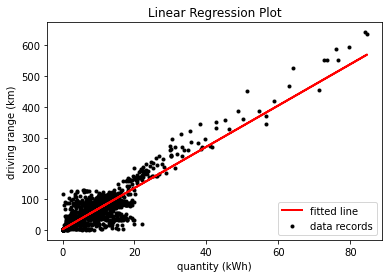

In [25]:
#"""plot driving range based on the battery quantity"""
quantity = X[:,0]
distance = y
quantity = np.reshape(quantity, newshape=(-1, 1))
#distance = np.reshape(distance, newshape=(-1, 1))

quantity_linear_reg = LinearRegression()
quantity_linear_reg.fit(X=quantity, y=distance)
q_slope = quantity_linear_reg.coef_[0]
q_intercept = quantity_linear_reg.intercept_
q_predicted_distances = q_intercept + q_slope * quantity

fig = plt.figure()
plt.scatter(x=quantity, y=distance, s=15, c='black', linewidths=0.1)
plt.plot(quantity, q_predicted_distances, c='red', linewidth=2)
plt.legend(('fitted line', 'data records'), loc='lower right')
plt.title(label='Linear Regression Plot')
plt.xlabel(xlabel='quantity (kWh)'), plt.ylabel(ylabel='driving range (km)')
plt.show()
# fig.savefig('range_to_quantity.png')


Here there is good correlation between the driving range and the quantity (energy consumption). Results obtained from linear regression model for the driving range in terms of the consumption energy amount.  

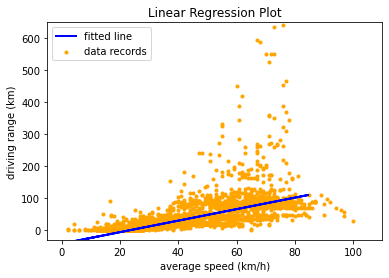

In [26]:
"""plot driving range based on the average speed"""
avg_speed = X[:,7]
avg_speed = np.reshape(avg_speed, newshape=(-1, 1))

speed_linear_reg = LinearRegression()
speed_linear_reg.fit(X=avg_speed, y=distance)
s_slope = speed_linear_reg.coef_[0]
s_intercept = speed_linear_reg.intercept_
s_predicted_distances = s_intercept + s_slope * quantity

fig = plt.figure()
plt.scatter(x=avg_speed, y=distance, s=15, c='orange', linewidths=0.1)
plt.plot(quantity, s_predicted_distances, c='blue', linewidth=2)
plt.legend(('fitted line', 'data records'), loc='upper left')
plt.title(label='Linear Regression Plot')
plt.xlabel(xlabel='average speed (km/h)'), plt.ylabel(ylabel='driving range (km)')
plt.xlim(-5, 110), plt.ylim(-30, 650)
plt.show()

Correlation between average speed and driving range is not noticeable. Figure shows linear regression model for driving range in terms of the average speed.

The results show that the best average MAE is obtained via RF which is 6.35 km.

In [34]:

data = np.array([('Linear Regression' , '10.631','10.206','87.27','88.037'),
                ('MLP','9.931','8.993','89.922','91.39'),
                ('Random Forest','6.987','6.348','92.295','92.998'),
                ('AdaBoost','17.134','13.048','83.388','88.008')])
columns = ['Model','Avergare MAE value', 'Best MAE value', 'Average r2 score', 'Best r2 score'] 
results = pd.DataFrame(data, columns = columns)
results

,Model,Avergare MAE value,Best MAE value,Average r2 score,Best r2 score
0,Linear Regression,10.631,10.206,87.27,88.037
1,MLP,9.931,8.993,89.922,91.39
2,Random Forest,6.987,6.348,92.295,92.998
3,AdaBoost,17.134,13.048,83.388,88.008
